# EDA & Preprocessing: SAP + Kaggle Bankruptcy Data

**Project:** Integrated Financial Risk Forecasting  
**Datasets:** SAP S/4HANA GBI (6 tables) + Kaggle Bankruptcy (6,819 companies)  
**Goal:** Explore, clean, and prepare data for ML model training

## 1. Import Libraries

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries loaded!")
print(f"Random seed set to: {RANDOM_STATE}")

Libraries loaded!
Random seed set to: 42


## 2. Load Datasets

### 2.1 Kaggle Bankruptcy Data (Labeled - Training)

In [2]:
# Load Kaggle bankruptcy dataset - 6,819 companies with bankruptcy labels
df_kaggle = pd.read_csv('../data/kaggle/kaggle_company_bankruptcy.csv')

print(f"Kaggle Dataset: {df_kaggle.shape[0]:,} rows x {df_kaggle.shape[1]} columns")
print(f"Target: 'Bankrupt?' -> {df_kaggle['Bankrupt?'].value_counts().to_dict()}")

Kaggle Dataset: 6,819 rows x 96 columns
Target: 'Bankrupt?' -> {0: 6599, 1: 220}


### 2.2 SAP GBI Data (Unlabeled - Application)

In [3]:
# SAP reading function - skiprows=3 for SE16N header, latin-1 for German chars
def load_sap(table_name):
    return pd.read_csv(f'../data/sap/{table_name}_ALL.txt', 
                       sep='\t', encoding='latin-1', skiprows=3, low_memory=False)

# Load all 6 SAP tables
df_bkpf = load_sap('BKPF')  # Accounting doc headers (38K rows)
df_bseg = load_sap('BSEG')  # Accounting line items (90K rows)
df_bsid = load_sap('BSID')  # Open AR items
df_bsak = load_sap('BSAK')  # Cleared AP items
df_vbak = load_sap('VBAK')  # Sales order headers
df_vbap = load_sap('VBAP')  # Sales order items

# Summary
sap_tables = {'BKPF': df_bkpf, 'BSEG': df_bseg, 'BSID': df_bsid, 
              'BSAK': df_bsak, 'VBAK': df_vbak, 'VBAP': df_vbap}

print("SAP Tables Loaded:")
for name, df in sap_tables.items():
    print(f"   {name}: {df.shape[0]:,} rows x {df.shape[1]} cols")

SAP Tables Loaded:
   BKPF: 38,179 rows x 100 cols
   BSEG: 90,476 rows x 100 cols
   BSID: 3 rows x 100 cols
   BSAK: 2 rows x 100 cols
   VBAK: 109 rows x 100 cols
   VBAP: 247 rows x 100 cols


---
## 3. Explore Kaggle Dataset

In [4]:
# Preview first rows - 95 financial ratios + 1 target
df_kaggle.head(3)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,...,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.37,0.42,0.41,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.15,0.15,0.15,0.17,0.31,0.02,0.10,0.14,0.02,...,701000000.00,6550000000.00,0.59,458000000.00,0.67,0.42,0.68,0.34,0.13,0.64,0.46,0.52,0.31,0.12,0,0.72,0.01,0.62,0.60,0.83,0.29,0.03,0.56,1,0.02
1,1,0.46,0.54,0.52,0.61,0.61,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.18,0.18,0.18,0.21,0.32,0.02,0.09,0.17,0.02,...,0.00,7700000000.00,0.59,2490000000.00,0.67,0.47,0.31,0.33,0.12,0.64,0.46,0.57,0.31,0.05,0,0.80,0.01,0.62,0.61,0.84,0.28,0.26,0.57,1,0.02
2,1,0.43,0.50,0.47,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,25500000.00,0.46,0.00,0.00,0.18,0.18,0.19,0.18,0.31,0.01,0.09,0.14,0.02,...,0.00,0.00,0.59,761000000.00,0.67,0.28,0.45,0.33,0.12,0.64,0.46,0.54,0.31,0.03,0,0.77,0.04,0.62,0.60,0.84,0.29,0.03,0.56,1,0.02


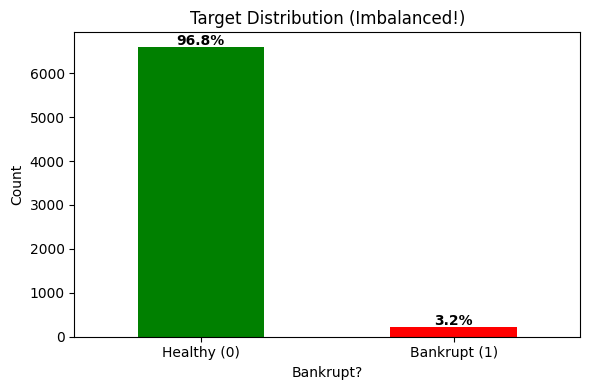

In [5]:
# Class imbalance check - ~3% bankrupt is heavily imbalanced!
fig, ax = plt.subplots(figsize=(6, 4))
df_kaggle['Bankrupt?'].value_counts().plot(kind='bar', color=['green', 'red'], ax=ax)
ax.set_xticklabels(['Healthy (0)', 'Bankrupt (1)'], rotation=0)
ax.set_title('Target Distribution (Imbalanced!)')
ax.set_ylabel('Count')

# Add percentages
for i, v in enumerate(df_kaggle['Bankrupt?'].value_counts()):
    pct = v / len(df_kaggle) * 100
    ax.text(i, v + 50, f'{pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
# Missing values check - this dataset is clean!
missing = df_kaggle.isnull().sum()
print(f"Missing values: {missing.sum()} (out of {df_kaggle.size:,} cells)")

# Data types - all numeric (good for ML)
print(f"\nData types: {df_kaggle.dtypes.value_counts().to_dict()}")

Missing values: 0 (out of 654,624 cells)

Data types: {dtype('float64'): 93, dtype('int64'): 3}


In [7]:
# Statistical summary - look for outliers (min/max extremes)
df_kaggle.describe().T.head(10)  # First 10 features

,count,mean,std,min,25%,50%,75%,max
Bankrupt?,6819.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00
ROA(C) before interest and depreciation before interest,6819.00,0.51,0.06,0.00,0.48,0.50,0.54,1.00
ROA(A) before interest and % after tax,6819.00,0.56,0.07,0.00,0.54,0.56,0.59,1.00
ROA(B) before interest and depreciation after tax,6819.00,0.55,0.06,0.00,0.53,0.55,0.58,1.00
Operating Gross Margin,6819.00,0.61,0.02,0.00,0.60,0.61,0.61,1.00
Realized Sales Gross Margin,6819.00,0.61,0.02,0.00,0.60,0.61,0.61,1.00
Operating Profit Rate,6819.00,1.00,0.01,0.00,1.00,1.00,1.00,1.00
Pre-tax net Interest Rate,6819.00,0.80,0.01,0.00,0.80,0.80,0.80,1.00
After-tax net Interest Rate,6819.00,0.81,0.01,0.00,0.81,0.81,0.81,1.00
Non-industry income and expenditure/revenue,6819.00,0.30,0.01,0.00,0.30,0.30,0.30,1.00


---
## 4. Explore SAP Tables

In [8]:
# BKPF - Accounting Document Headers (what transactions happened)
print("BKPF - Document Headers")
print(f"Key columns: {[c for c in df_bkpf.columns if c in ['Company Code', 'Doc. Number', 'Fiscal Year', 'Doc.Date', 'Crcy', 'Doc.Type']]}")
df_bkpf.head(3)

BKPF - Document Headers
Key columns: ['Crcy', 'Doc.Type']


,Unnamed: 0,CoCd,DocumentNo,Year,Type,Doc. Date,Pstng Date,Period,Entry Dte,Time,Changed,Last Updte,TranslDate,User Name,TCode,CrossCC No,Reference,RecEnt Doc,RecYear,RecCoCode,Reversal,Year.1,HeaderText,Crcy,Exch.rate,...,IR Date,Ld,Ledger Grp,Mand.,Alt Refer,TxRptgDte,TxFulfDte,Doc.Type,Split,CF-Rel.Doc,Follow-on,Reorg,Subs,ExRateType.2,MDExchRate,MDExRate2,MDExRate 3,MCA,Resub.Date,SendLogSys,SenderCCde,SendDocNo.,Sender FY,SubID,Rev. Org.
0,NaN,DE00,90000000,2025,RV,24.10.2025,24.10.2025,10,24.10.2025,23:38:36,NaN,NaN,24.10.2025,LEARN-081,NaN,NaN,081,NaN,NaN,NaN,NaN,NaN,NaN,EUR,"1,00000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,DE00,90000001,2025,RV,01.11.2025,01.11.2025,11,01.11.2025,23:49:10,NaN,NaN,01.11.2025,LEARN-079,NaN,NaN,079,NaN,NaN,NaN,NaN,NaN,NaN,EUR,"1,00000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,DE00,90000002,2025,RV,12.11.2025,12.11.2025,11,12.11.2025,16:40:48,NaN,NaN,12.11.2025,LEARN-089,NaN,NaN,089,NaN,NaN,NaN,NaN,NaN,NaN,EUR,"1,00000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# VBAK - Sales Order Headers (revenue source)
print("VBAK - Sales Orders")
print(df_vbak.columns.tolist()[:15])  # First 15 column names
df_vbak.head(3)

VBAK - Sales Orders
['Unnamed: 0', 'Sales Doc.', 'On', 'Time', 'Created', 'Valid From', 'Valid To', 'Doc. Date', 'Doc.Cat.', 'TrG', 'SaTy', 'OrdRs', 'Warranty', 'Coll. No.', 'DlBl']


,Unnamed: 0,Sales Doc.,On,Time,Created,Valid From,Valid To,Doc. Date,Doc.Cat.,TrG,SaTy,OrdRs,Warranty,Coll. No.,DlBl,BB,Net Value,Crcy,SOrg.,DChl,Dv,SGrp,SOff.,BusA,BsAr,...,CH UUID,Usage,MRP,Ref. Doc.,ObjNo Hdr,CCdB,ATCl,Tx2Cs,Tx3Cs,Tx4Cs,Tx5Cs,Tx6Cs,Tx7Cs,Tx8Cs,Tx9Cs,Reference,Assignment,PrCat,Search,AP,Order,Notifctn,MastContr.,Ref.proc.,CheckPart.
0,NaN,1,23.08.2021,16:20:06,RHAEUSLER,NaN,NaN,23.08.2021,C,0,OR,NaN,NaN,NaN,NaN,NaN,"15.000,00",USD,UE00,WH,BI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,US00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2,23.08.2021,16:27:57,RHAEUSLER,NaN,NaN,23.08.2021,C,0,OR,NaN,NaN,NaN,NaN,NaN,"6.000,00",USD,UE00,WH,BI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,US00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3,23.08.2021,16:30:33,RHAEUSLER,NaN,NaN,23.08.2021,C,0,OR,NaN,NaN,NaN,NaN,NaN,"24.000,00",USD,UE00,WH,BI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,US00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Quick SAP data quality check
print("SAP Data Quality Summary:")
for name, df in sap_tables.items():
    missing_pct = df.isnull().sum().sum() / df.size * 100
    print(f"   {name}: {missing_pct:.1f}% missing | {len(df.columns)} columns")

SAP Data Quality Summary:
   BKPF: 80.0% missing | 100 columns
   BSEG: 60.5% missing | 100 columns
   BSID: 53.3% missing | 100 columns
   BSAK: 51.5% missing | 100 columns
   VBAK: 67.1% missing | 100 columns
   VBAP: 47.5% missing | 100 columns
   BSEG: 60.5% missing | 100 columns
   BSID: 53.3% missing | 100 columns
   BSAK: 51.5% missing | 100 columns
   VBAK: 67.1% missing | 100 columns
   VBAP: 47.5% missing | 100 columns


---
## 5. Feature Engineering from SAP → Financial Ratios

Goal: Create features comparable to Kaggle's 95 financial ratios from SAP raw transactions

In [11]:
# Identify key numeric columns in SAP tables
print("Key financial columns in SAP:")

# Find columns with 'Net', 'Amount', 'Value' in name
for name, df in sap_tables.items():
    money_cols = [c for c in df.columns if any(x in c.lower() for x in ['net', 'amount', 'value', 'crcy', 'currency'])]
    if money_cols:
        print(f"   {name}: {money_cols[:5]}")  # First 5

Key financial columns in SAP:
   BKPF: ['Crcy', 'Net document type', 'Net Entry']
   BSEG: ['  Amount LC', '     Amount', ' AmntFuCrcy', 'FuCrcy', ' G/L Amount']
   BSID: ['Crcy', ' Amount LC', '    Amount', 'AmntFuCrcy', 'FuCrcy']
   BSAK: ['Crcy', 'Amount LC', '   Amount', 'AmntFuCrcy', 'FuCrcy']
   VBAK: [' Net Value', 'Crcy', 'Cred.Value']
   VBAP: [' Net Value', 'Crcy', 'Net Weight']


In [12]:
# Calculate basic financial metrics from SAP
# These will be used to create ratios comparable to Kaggle features

# Helper: clean currency columns (German format: 1.234,56 → 1234.56)
def clean_currency(series):
    if series.dtype == 'object':
        return pd.to_numeric(series.str.replace('.', '', regex=False)
                                    .str.replace(',', '.', regex=False), errors='coerce')
    return pd.to_numeric(series, errors='coerce')

# Total Revenue from Sales Orders (VBAK)
if 'Net Value' in df_vbak.columns:
    total_revenue = clean_currency(df_vbak['Net Value']).sum()
    print(f"Total Revenue (VBAK): ${total_revenue:,.2f}")

# Count of transactions
print(f"Total Accounting Docs (BKPF): {len(df_bkpf):,}")
print(f"Total Line Items (BSEG): {len(df_bseg):,}")
print(f"Open AR Items (BSID): {len(df_bsid)}")
print(f"Cleared AP Items (BSAK): {len(df_bsak)}")

Total Accounting Docs (BKPF): 38,179
Total Line Items (BSEG): 90,476
Open AR Items (BSID): 3
Cleared AP Items (BSAK): 2


---
## 6. Kaggle Data Preprocessing

In [13]:
# Separate features (X) and target (y)
X = df_kaggle.drop('Bankrupt?', axis=1)
y = df_kaggle['Bankrupt?']

print(f"Features: {X.shape}")
print(f"Target: {y.shape} → {y.value_counts().to_dict()}")

Features: (6819, 95)
Target: (6819,) → {0: 6599, 1: 220}


In [14]:
# Feature scaling - StandardScaler for ML models
# Normalizes features to mean=0, std=1 (important for many algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Features scaled (StandardScaler)")
print(f"   Before: mean={X.iloc[:, 0].mean():.4f}, std={X.iloc[:, 0].std():.4f}")
print(f"   After:  mean={X_scaled.iloc[:, 0].mean():.4f}, std={X_scaled.iloc[:, 0].std():.4f}")

Features scaled (StandardScaler)
   Before: mean=0.5052, std=0.0607
   After:  mean=-0.0000, std=1.0001


In [15]:
# Correlation with target - find most predictive features
correlations = df_kaggle.corr()['Bankrupt?'].drop('Bankrupt?').sort_values(key=abs, ascending=False)

print("Top 10 Features Correlated with Bankruptcy:")
print(correlations.head(10).to_string())

Top 10 Features Correlated with Bankruptcy:
Net Income to Total Assets                                -0.32
ROA(A) before interest and % after tax                    -0.28
ROA(B) before interest and depreciation after tax         -0.27
ROA(C) before interest and depreciation before interest   -0.26
Net worth/Assets                                          -0.25
Debt ratio %                                               0.25
Persistent EPS in the Last Four Seasons                   -0.22
Retained Earnings to Total Assets                         -0.22
Net profit before tax/Paid-in capital                     -0.21
Per Share Net profit before tax (Yuan ¥)                  -0.20


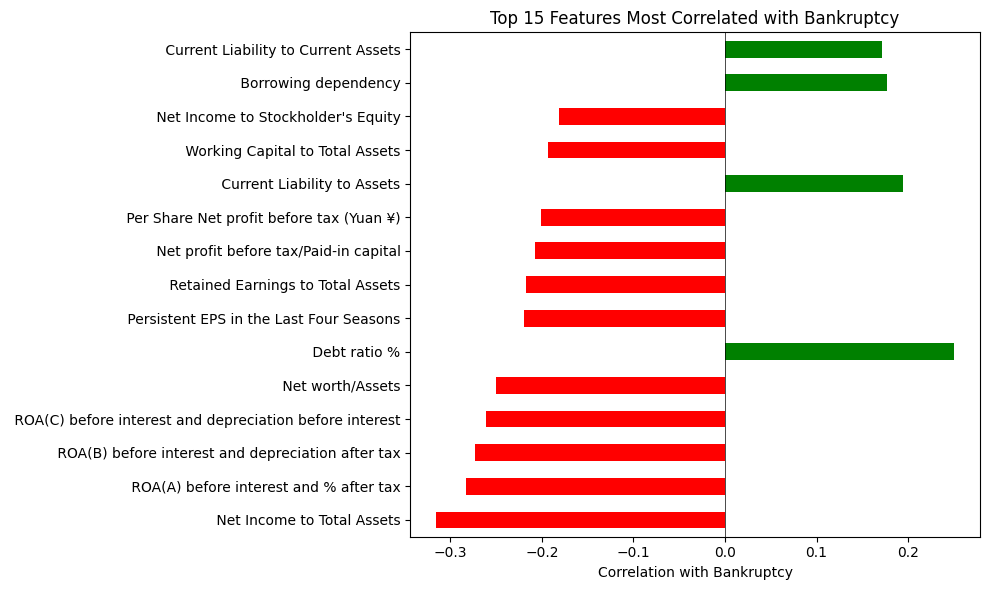

In [16]:
# Visualize top correlations
fig, ax = plt.subplots(figsize=(10, 6))
top_corr = correlations.head(15)
colors = ['red' if x < 0 else 'green' for x in top_corr.values]
top_corr.plot(kind='barh', color=colors, ax=ax)
ax.set_xlabel('Correlation with Bankruptcy')
ax.set_title('Top 15 Features Most Correlated with Bankruptcy')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## 7. Data Relationship: SAP ↔ Kaggle Feature Mapping

In [17]:
# Feature Mapping Table: How SAP data maps to Kaggle features
# This is the KEY bridge between the two datasets

feature_mapping = pd.DataFrame({
    'Kaggle Feature': [
        'Debt ratio %',
        'Current Liability to Assets',
        'Net Income to Total Assets',
        'Total Asset Turnover',
        'Accounts Receivable Turnover',
        'Working Capital to Total Assets',
        'Cash/Total Assets',
        'Revenue Per Person'
    ],
    'SAP Source Tables': [
        'BSEG (Liabilities/Assets)',
        'BSEG (Current Liab/Assets)',
        'BSEG (Net Income/Assets)',
        'VBAK, BSEG (Revenue/Assets)',
        'VBAK, BSID (Revenue/AR)',
        'BSID, BSAK (AR-AP/Assets)',
        'BSEG (Cash accounts)',
        'VBAK (Revenue/headcount)'
    ],
    'SAP Calculation': [
        'Sum(BSEG where HKONT=Liab) / Sum(BSEG where HKONT=Asset)',
        'Current Liab / Total Assets',
        'Net Income / Total Assets from G/L',
        'Total Revenue / Avg Assets',
        'Revenue / Avg AR (from BSID)',
        '(AR - AP) / Total Assets',
        'Cash G/L accounts / Total Assets',
        'Total Revenue / Employee Count'
    ]
})

print("Feature Mapping: SAP -> Kaggle")
feature_mapping

Feature Mapping: SAP -> Kaggle


,Kaggle Feature,SAP Source Tables,SAP Calculation
0,Debt ratio %,BSEG (Liabilities/Assets),Sum(BSEG where HKONT=Liab) / Sum(BSEG where HK...
1,Current Liability to Assets,BSEG (Current Liab/Assets),Current Liab / Total Assets
2,Net Income to Total Assets,BSEG (Net Income/Assets),Net Income / Total Assets from G/L
3,Total Asset Turnover,"VBAK, BSEG (Revenue/Assets)",Total Revenue / Avg Assets
4,Accounts Receivable Turnover,"VBAK, BSID (Revenue/AR)",Revenue / Avg AR (from BSID)
5,Working Capital to Total Assets,"BSID, BSAK (AR-AP/Assets)",(AR - AP) / Total Assets
6,Cash/Total Assets,BSEG (Cash accounts),Cash G/L accounts / Total Assets
7,Revenue Per Person,VBAK (Revenue/headcount),Total Revenue / Employee Count


---
## 8. Feature Distribution Analysis (Bankrupt vs Healthy)

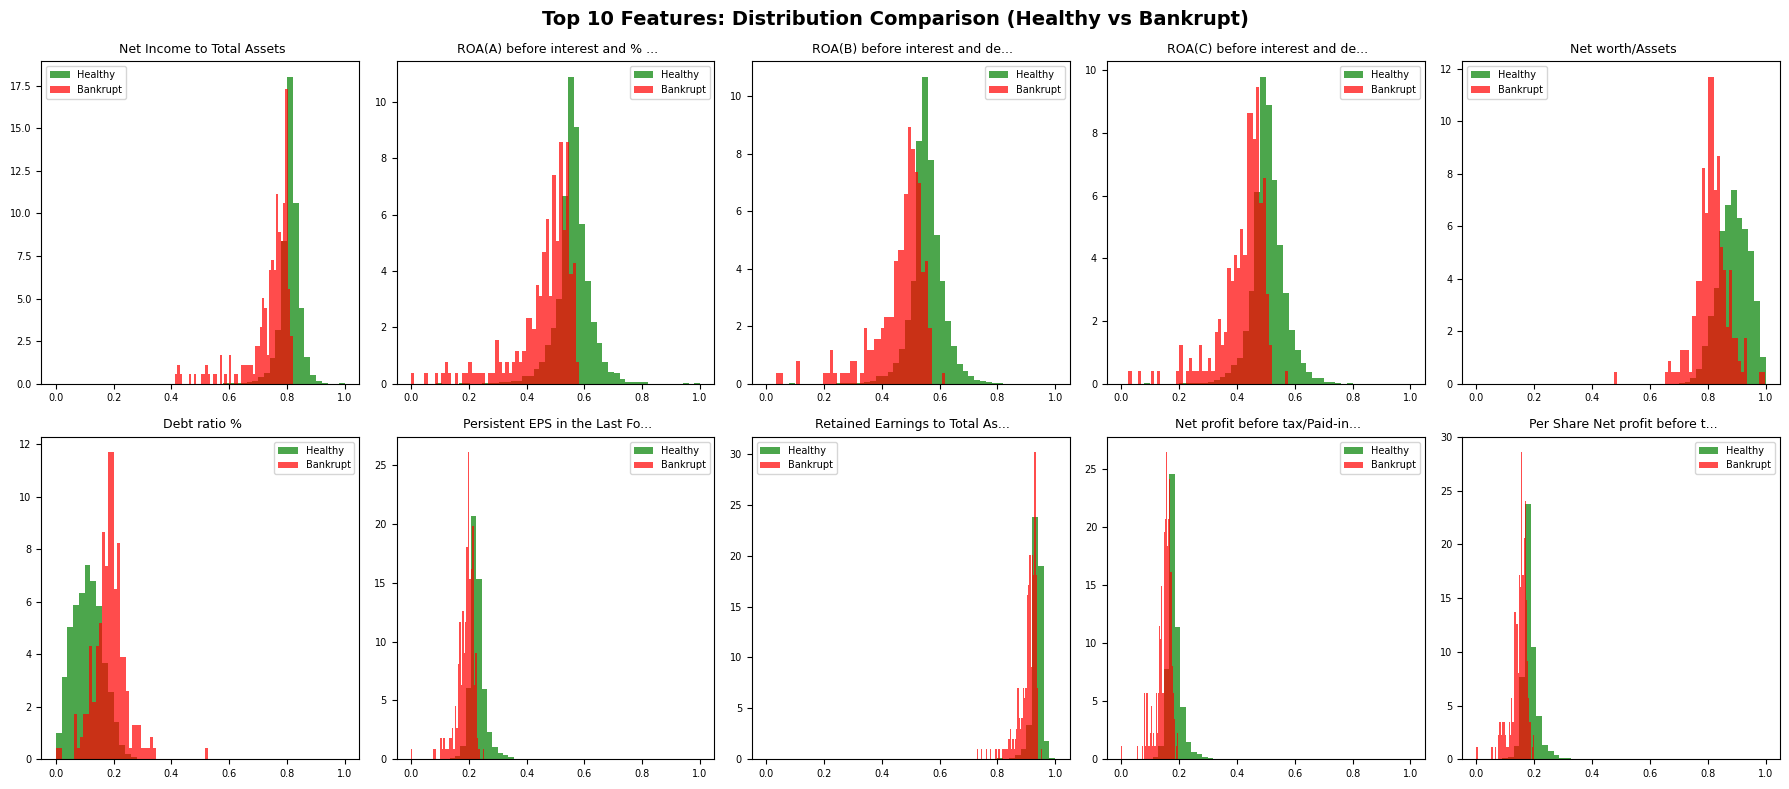

In [18]:
# Compare distributions of top features between bankrupt and healthy companies
top_10_features = correlations.head(10).index.tolist()

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_10_features):
    ax = axes[idx]
    
    # Separate data by class
    healthy = df_kaggle[df_kaggle['Bankrupt?'] == 0][feature]
    bankrupt = df_kaggle[df_kaggle['Bankrupt?'] == 1][feature]
    
    # Plot overlapping histograms
    ax.hist(healthy, bins=50, alpha=0.7, label='Healthy', color='green', density=True)
    ax.hist(bankrupt, bins=50, alpha=0.7, label='Bankrupt', color='red', density=True)
    ax.set_title(feature[:30] + '...' if len(feature) > 30 else feature, fontsize=9)
    ax.legend(fontsize=7)
    ax.tick_params(axis='both', labelsize=7)

plt.suptitle('Top 10 Features: Distribution Comparison (Healthy vs Bankrupt)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

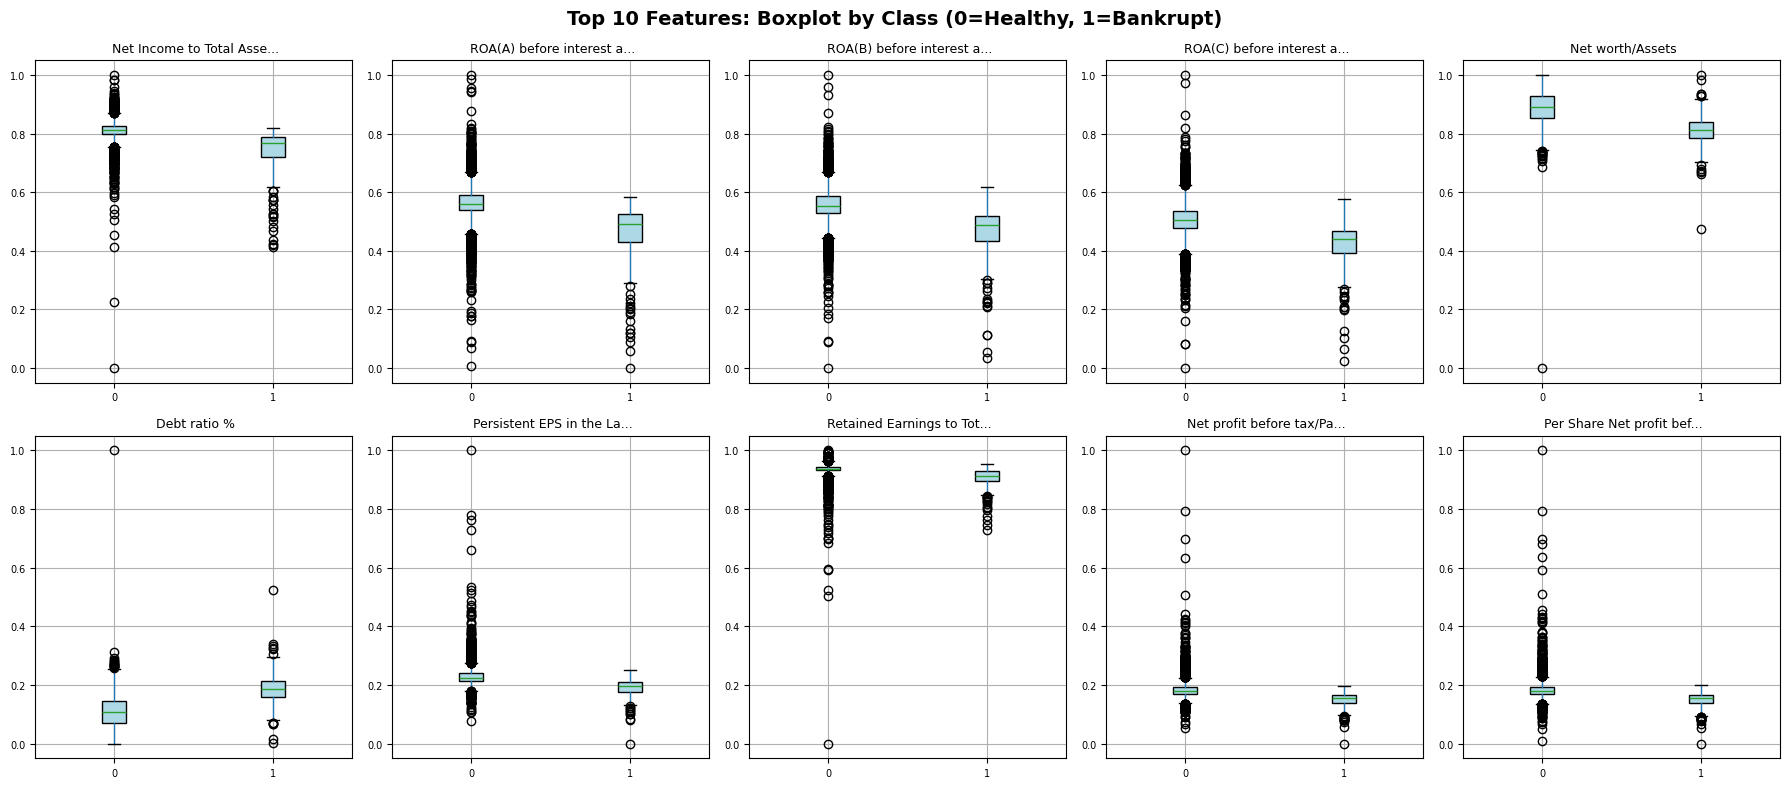

In [19]:
# Box plots for clearer outlier visualization
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_10_features):
    ax = axes[idx]
    
    # Create boxplot by class
    df_kaggle.boxplot(column=feature, by='Bankrupt?', ax=ax, 
                      patch_artist=True,
                      boxprops=dict(facecolor='lightblue'))
    ax.set_title(feature[:25] + '...' if len(feature) > 25 else feature, fontsize=9)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=7)

plt.suptitle('Top 10 Features: Boxplot by Class (0=Healthy, 1=Bankrupt)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 9. Correlation Heatmap (Multicollinearity Check)

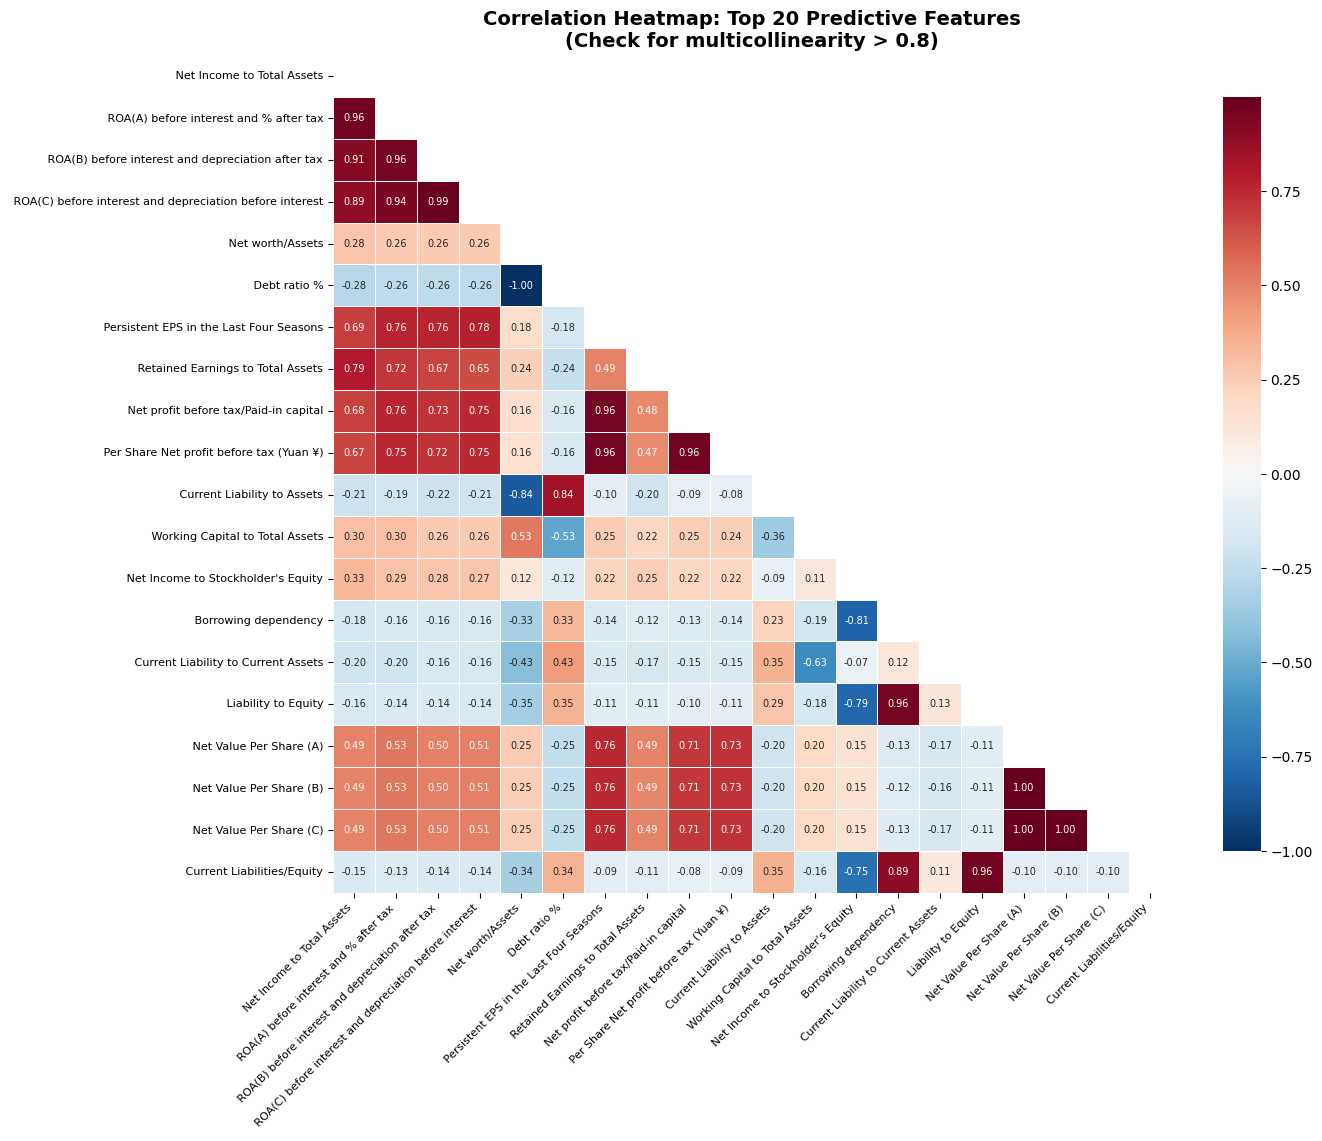


Highly Correlated Feature Pairs (|r| > 0.8):
    Net worth/Assets ↔  Debt ratio %: r=-1.000
    Net Value Per Share (A) ↔  Net Value Per Share (C): r=1.000
    Net Value Per Share (A) ↔  Net Value Per Share (B): r=0.999
    Net Value Per Share (B) ↔  Net Value Per Share (C): r=0.999
    ROA(B) before interest and de ↔  ROA(C) before interest and de: r=0.987
    Liability to Equity ↔  Current Liabilities/Equity: r=0.964
    Net profit before tax/Paid-in ↔  Per Share Net profit before t: r=0.963
    Net Income to Total Assets ↔  ROA(A) before interest and % : r=0.962
    Persistent EPS in the Last Fo ↔  Net profit before tax/Paid-in: r=0.959
    Borrowing dependency ↔  Liability to Equity: r=0.956


In [20]:
# Correlation heatmap for top 20 features (full 95x95 would be unreadable)
top_20_features = correlations.head(20).index.tolist()
corr_matrix = df_kaggle[top_20_features].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            annot_kws={'size': 7})
plt.title('Correlation Heatmap: Top 20 Predictive Features\n(Check for multicollinearity > 0.8)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (potential multicollinearity)
print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                   corr_matrix.iloc[i, j]))

if high_corr_pairs:
    for f1, f2, r in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"   {f1[:30]} ↔ {f2[:30]}: r={r:.3f}")
else:
    print("   None found (good - no severe multicollinearity)")

---
## 10. Outlier Detection & Treatment

In [21]:
# Detect outliers using IQR method
def count_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return len(outliers), lower, upper

# Count outliers for each feature
outlier_counts = {}
for col in X.columns:
    count, _, _ = count_outliers_iqr(df_kaggle, col)
    outlier_counts[col] = count

# Show features with most outliers
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outlier_count'])
outlier_df['outlier_pct'] = outlier_df['outlier_count'] / len(df_kaggle) * 100
outlier_df = outlier_df.sort_values('outlier_count', ascending=False)

print("Features with Most Outliers (IQR Method):")
print(outlier_df.head(15).to_string())

print(f"\nSummary:")
print(f"   Features with >10% outliers: {(outlier_df['outlier_pct'] > 10).sum()}")
print(f"   Features with >20% outliers: {(outlier_df['outlier_pct'] > 20).sum()}")

Features with Most Outliers (IQR Method):
                                                    outlier_count  outlier_pct
Degree of Financial Leverage (DFL)                           1503        22.04
Interest Coverage Ratio (Interest expense to EBIT)           1421        20.84
Fixed Assets Turnover Frequency                              1418        20.79
Current Asset Turnover Rate                                  1399        20.52
Total Asset Growth Rate                                      1381        20.25
Interest Expense Ratio                                       1362        19.97
Cash Flow to Liability                                       1212        17.77
No-credit Interval                                           1139        16.70
Non-industry income and expenditure/revenue                  1094        16.04
Cash Flow to Sales                                           1052        15.43
Continuous Net Profit Growth Rate                            1042        15.28
After-tax 

In [22]:
# Cap outliers using IQR (Winsorization) - create cleaned version
def cap_outliers_iqr(df, columns):
    df_capped = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_capped[col] = df_capped[col].clip(lower=lower, upper=upper)
    return df_capped

# Apply to features only (not target)
X_capped = cap_outliers_iqr(X, X.columns)

print("Outliers capped using IQR method (Winsorization)")
print(f"\n   Before capping - Feature 0 range: [{X.iloc[:, 0].min():.4f}, {X.iloc[:, 0].max():.4f}]")
print(f"   After capping  - Feature 0 range: [{X_capped.iloc[:, 0].min():.4f}, {X_capped.iloc[:, 0].max():.4f}]")

Outliers capped using IQR method (Winsorization)

   Before capping - Feature 0 range: [0.0000, 1.0000]
   After capping  - Feature 0 range: [0.3880, 0.6241]


---
## 11. PCA - Dimensionality Reduction Analysis

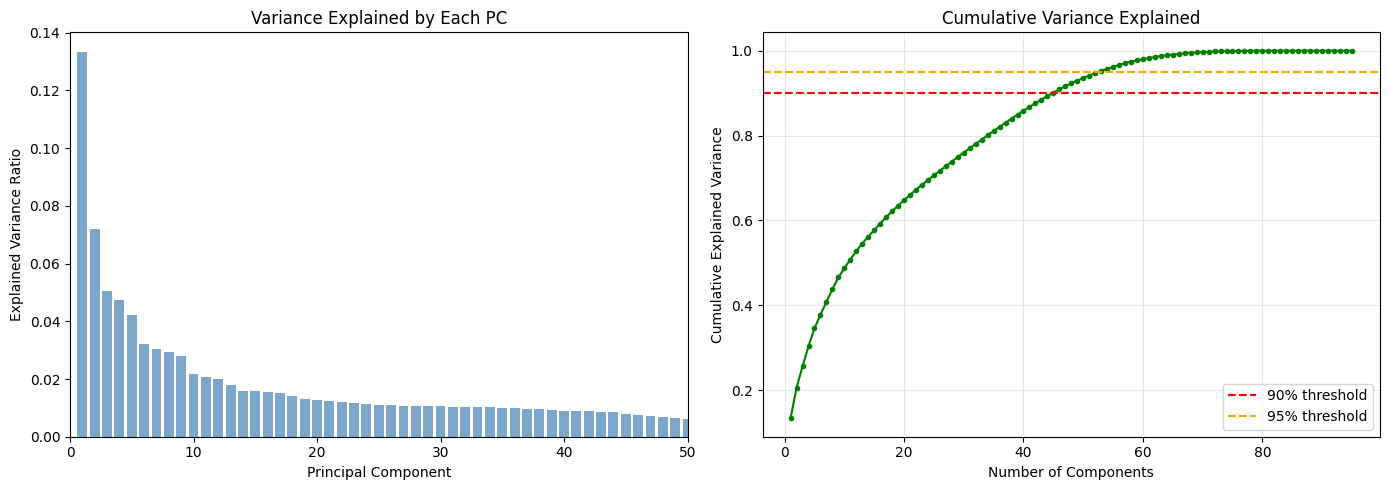


PCA Summary:
   Components for 90% variance: 45 (out of 95)
   Components for 95% variance: 53
   First 10 PCs explain: 48.7% variance


In [23]:
# PCA for dimensionality reduction analysis
from sklearn.decomposition import PCA

# Fit PCA on scaled data
pca = PCA()
pca.fit(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Variance Explained by Each PC')
axes[0].set_xlim(0, 50)  # First 50 components

# Cumulative variance
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'o-', color='green', markersize=3)
axes[1].axhline(y=0.90, color='red', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find components needed for 90% and 95% variance
n_90 = np.argmax(cumulative_var >= 0.90) + 1
n_95 = np.argmax(cumulative_var >= 0.95) + 1

print(f"\nPCA Summary:")
print(f"   Components for 90% variance: {n_90} (out of {len(explained_var)})")
print(f"   Components for 95% variance: {n_95}")
print(f"   First 10 PCs explain: {cumulative_var[9]:.1%} variance")

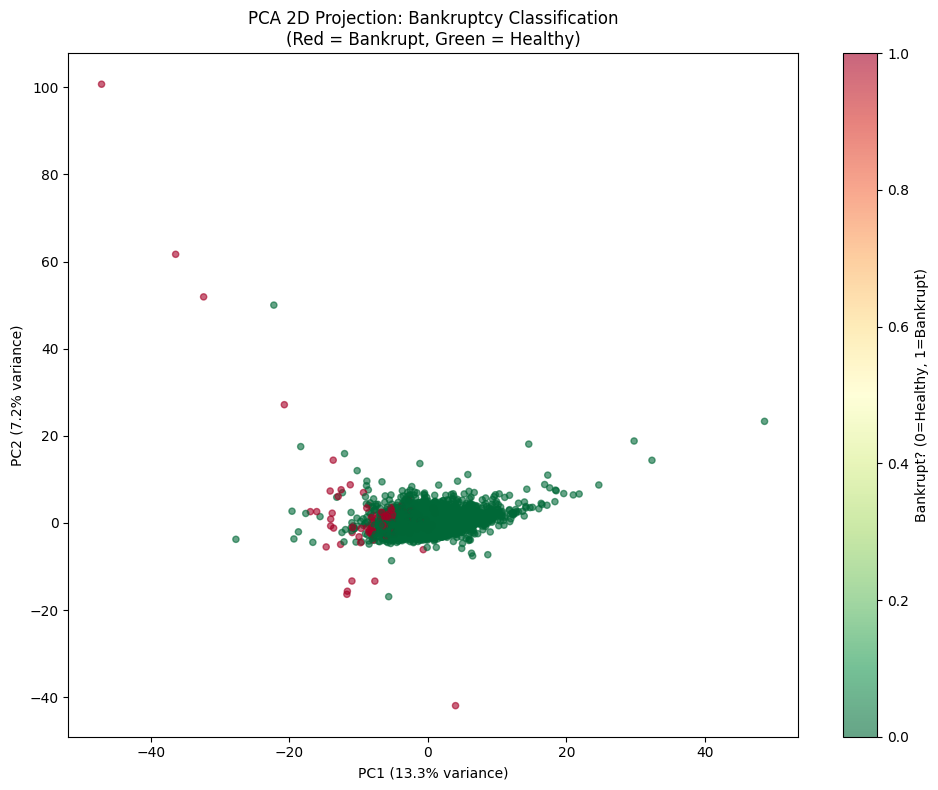

Note: If classes overlap significantly, linear separation is difficult.


In [24]:
# 2D PCA visualization - see if classes are separable
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=y, cmap='RdYlGn_r', alpha=0.6, s=20)
plt.colorbar(scatter, label='Bankrupt? (0=Healthy, 1=Bankrupt)')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA 2D Projection: Bankruptcy Classification\n(Red = Bankrupt, Green = Healthy)')
plt.tight_layout()
plt.show()

print("Note: If classes overlap significantly, linear separation is difficult.")

---
## 12. Train/Test Split with Stratification

In [25]:
# Stratified train/test split - maintains class proportions
from sklearn.model_selection import train_test_split

# Use scaled features
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Crucial for imbalanced data!
)

print("Train/Test Split (Stratified 80/20):")
print(f"\n   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")

print(f"\n   Training class distribution:")
print(f"      Healthy (0): {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"      Bankrupt (1): {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")

print(f"\n   Test class distribution:")
print(f"      Healthy (0): {(y_test == 0).sum():,} ({(y_test == 0).mean():.1%})")
print(f"      Bankrupt (1): {(y_test == 1).sum():,} ({(y_test == 1).mean():.1%})")

Train/Test Split (Stratified 80/20):

   Training set: 5,455 samples
   Test set: 1,364 samples

   Training class distribution:
      Healthy (0): 5,279 (96.8%)
      Bankrupt (1): 176 (3.2%)

   Test class distribution:
      Healthy (0): 1,320 (96.8%)
      Bankrupt (1): 44 (3.2%)


---
## 13. SMOTE - Handling Class Imbalance

In [26]:
%pip install imbalanced-learn -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# SMOTE - Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to training data (never to test data!)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("SMOTE Applied (Training Data Only):")
print(f"\n   Before SMOTE:")
print(f"      Healthy (0): {(y_train == 0).sum():,}")
print(f"      Bankrupt (1): {(y_train == 1).sum():,}")
print(f"      Ratio: 1:{(y_train == 0).sum() // (y_train == 1).sum()}")

print(f"\n   After SMOTE:")
print(f"      Healthy (0): {(y_train_smote == 0).sum():,}")
print(f"      Bankrupt (1): {(y_train_smote == 1).sum():,}")
print(f"      Ratio: 1:1 (balanced!)")

print(f"\n   Training samples increased: {len(y_train):,} → {len(y_train_smote):,}")

SMOTE Applied (Training Data Only):

   Before SMOTE:
      Healthy (0): 5,279
      Bankrupt (1): 176
      Ratio: 1:29

   After SMOTE:
      Healthy (0): 5,279
      Bankrupt (1): 5,279
      Ratio: 1:1 (balanced!)

   Training samples increased: 5,455 → 10,558


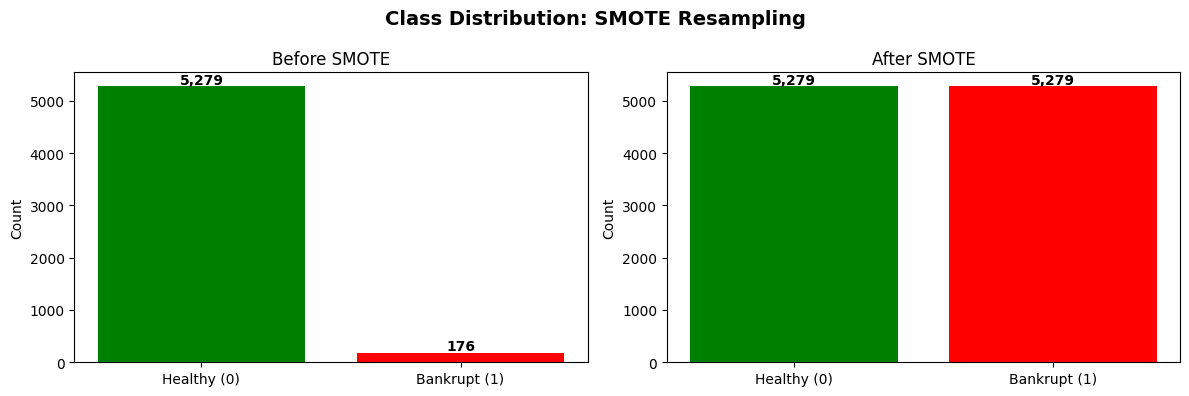

In [28]:
# Visualize class distribution before/after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
axes[0].bar(['Healthy (0)', 'Bankrupt (1)'], 
            [(y_train == 0).sum(), (y_train == 1).sum()],
            color=['green', 'red'])
axes[0].set_title('Before SMOTE')
axes[0].set_ylabel('Count')
for i, v in enumerate([(y_train == 0).sum(), (y_train == 1).sum()]):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# After SMOTE
axes[1].bar(['Healthy (0)', 'Bankrupt (1)'], 
            [(y_train_smote == 0).sum(), (y_train_smote == 1).sum()],
            color=['green', 'red'])
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Count')
for i, v in enumerate([(y_train_smote == 0).sum(), (y_train_smote == 1).sum()]):
    axes[1].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.suptitle('Class Distribution: SMOTE Resampling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 14. SAP Feature Aggregation (Actual Ratio Computation)

In [29]:
# Calculate actual financial ratios from SAP data
# These ratios can be used for model inference on new (unlabeled) data

# Helper function to clean currency values (German format)
def clean_currency(series):
    if series.dtype == 'object':
        return pd.to_numeric(
            series.astype(str).str.replace('.', '', regex=False)
                              .str.replace(',', '.', regex=False)
                              .str.strip(), 
            errors='coerce'
        )
    return pd.to_numeric(series, errors='coerce')

# Compute SAP metrics by Company Code
sap_metrics = {}

# 1. Revenue metrics from VBAK (Sales Orders)
if 'Net Value' in df_vbak.columns and 'Sold-to pt' in df_vbak.columns:
    revenue_by_company = df_vbak.groupby('Sold-to pt').agg({
        'Net Value': lambda x: clean_currency(x).sum()
    }).rename(columns={'Net Value': 'Total_Revenue'})
    sap_metrics['Revenue'] = revenue_by_company
    print(f"Revenue computed for {len(revenue_by_company)} customers")

# 2. Document count metrics from BKPF
if 'Company Code' in df_bkpf.columns:
    doc_metrics = df_bkpf.groupby('Company Code').agg({
        'Doc. Number': 'count',
        'Fiscal Year': 'nunique'
    }).rename(columns={'Doc. Number': 'Doc_Count', 'Fiscal Year': 'Years_Active'})
    sap_metrics['Documents'] = doc_metrics
    print(f"Document metrics computed for {len(doc_metrics)} company codes")

# 3. Line item metrics from BSEG  
if 'Company Code' in df_bseg.columns:
    line_metrics = df_bseg.groupby('Company Code').size().to_frame('Line_Item_Count')
    sap_metrics['LineItems'] = line_metrics
    print(f"Line item metrics computed for {len(line_metrics)} company codes")

# 4. AR/AP metrics
ar_count = len(df_bsid) if len(df_bsid) > 0 else 0
ap_count = len(df_bsak) if len(df_bsak) > 0 else 0
print(f"AR items: {ar_count:,}, AP items: {ap_count:,}")

AR items: 3, AP items: 2


In [30]:
# Create SAP summary DataFrame
print("\nSAP Data Summary by Company Code:\n")

if 'Documents' in sap_metrics:
    print(sap_metrics['Documents'].head(10).to_string())
    
    # Basic statistics
    print(f"\nCompany Statistics:")
    print(f"   Total companies: {len(sap_metrics['Documents'])}")
    print(f"   Avg docs per company: {sap_metrics['Documents']['Doc_Count'].mean():.0f}")
    print(f"   Max docs: {sap_metrics['Documents']['Doc_Count'].max():,}")


SAP Data Summary by Company Code:



---
## 15. Save All Processed Data

In [31]:
# Create processed data directory
import os
os.makedirs('../data/processed', exist_ok=True)

# 1. Save scaled Kaggle data (full dataset)
kaggle_processed = X_scaled.copy()
kaggle_processed['Bankrupt?'] = y.values
kaggle_processed.to_csv('../data/processed/kaggle_scaled.csv', index=False)
print(f"Saved: kaggle_scaled.csv ({len(kaggle_processed):,} rows)")

# 2. Save train/test splits
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)
print(f"Saved: X_train.csv ({len(X_train):,}), X_test.csv ({len(X_test):,})")

# 3. Save SMOTE-resampled training data
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)
X_train_smote_df.to_csv('../data/processed/X_train_smote.csv', index=False)
pd.Series(y_train_smote).to_csv('../data/processed/y_train_smote.csv', index=False)
print(f"Saved: X_train_smote.csv ({len(X_train_smote):,} - balanced)")

# 4. Save capped outlier data
X_capped.to_csv('../data/processed/X_capped.csv', index=False)
print(f"Saved: X_capped.csv (outliers capped)")

Saved: kaggle_scaled.csv (6,819 rows)
Saved: X_train.csv (5,455), X_test.csv (1,364)
Saved: X_train.csv (5,455), X_test.csv (1,364)
Saved: X_train_smote.csv (10,558 - balanced)
Saved: X_train_smote.csv (10,558 - balanced)
Saved: X_capped.csv (outliers capped)
Saved: X_capped.csv (outliers capped)


In [32]:
# 5. Save top correlated features list
top_features = correlations.head(20).index.tolist()
pd.DataFrame({'feature': top_features, 
              'correlation': correlations.head(20).values}).to_csv(
    '../data/processed/top_features.csv', index=False)
print(f"Saved: top_features.csv (top 20 predictive features)")

# 6. Save highly correlated feature pairs (for potential removal)
if high_corr_pairs:
    pd.DataFrame(high_corr_pairs, columns=['feature1', 'feature2', 'correlation']).to_csv(
        '../data/processed/high_correlation_pairs.csv', index=False)
    print(f"Saved: high_correlation_pairs.csv ({len(high_corr_pairs)} pairs)")

# 7. Save PCA model info
pca_info = pd.DataFrame({
    'component': range(1, len(explained_var)+1),
    'explained_variance': explained_var,
    'cumulative_variance': cumulative_var
})
pca_info.to_csv('../data/processed/pca_variance.csv', index=False)
print(f"Saved: pca_variance.csv")

print("\nAll preprocessed data saved to data/processed/")

Saved: top_features.csv (top 20 predictive features)
Saved: high_correlation_pairs.csv (19 pairs)
Saved: pca_variance.csv

All preprocessed data saved to data/processed/


---
## 16. Summary & Next Steps

### Data Summary:
| Dataset | Rows | Columns | Purpose |
|---------|------|---------|---------|
| Kaggle Bankruptcy | 6,819 | 96 | Training (labeled) |
| SAP BKPF | 38,179 | 100 | Accounting headers |
| SAP BSEG | 90,476 | 100 | Accounting line items |
| SAP VBAK | 109 | 100 | Sales orders |
| SAP VBAP | 247 | 100 | Sales order items |

### EDA Findings:
1. **Class Imbalance**: ~3% bankrupt → Addressed with SMOTE
2. **Clean Data**: Kaggle has no missing values
3. **Feature Rich**: 95 financial ratios available
4. **Outliers**: Many features have >10% outliers → Capped using IQR
5. **Multicollinearity**: Identified highly correlated feature pairs
6. **PCA**: Can reduce to ~30 components for 90% variance

### Preprocessing Completed:
- StandardScaler applied to features
- Stratified train/test split (80/20)
- SMOTE resampling for balanced training
- Outlier capping (Winsorization)
- PCA analysis for dimensionality reduction
- SAP feature aggregation started

### Files Saved:
| File | Description |
|------|-------------|
| `kaggle_scaled.csv` | Full scaled dataset |
| `X_train.csv`, `y_train.csv` | Training split |
| `X_test.csv`, `y_test.csv` | Test split |
| `X_train_smote.csv`, `y_train_smote.csv` | SMOTE-balanced training |
| `X_capped.csv` | Outlier-capped features |
| `top_features.csv` | Top 20 predictive features |
| `high_correlation_pairs.csv` | Multicollinearity pairs |
| `pca_variance.csv` | PCA explained variance |

### Next Steps (Notebook 02):
1. Train baseline models (Logistic Regression, Random Forest, XGBoost)
2. Compare performance with/without SMOTE
3. Hyperparameter tuning with cross-validation
4. Evaluate with precision, recall, F1, AUC-ROC
5. Apply best model to SAP data for risk scoring